# Contrastive learning density estimation

Author: Christoph Weniger, June 2020

Math behind this can be found here: https://www.notion.so/cweniger/The-math-of-contrastive-learning-6991de9a04c74d84be61239717fdb57c

## Purpose

- Prototype for systematically test and compare density estimation models

In [8]:
import torch
from torch import nn as nn
import scipy
import numpy as np
from tqdm import tqdm
import pylab as plt
from IPython import display

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_hidden = 100):
        super().__init__()
        self.fc1 = nn.Linear(1, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)

        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 1)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        #z = torch.relu(self.fc3(z))        
        #z = torch.relu(self.fc4(z))                
        #z = torch.relu(self.fc5(z))                        
        z = self.fc6(z)
        return z

In [3]:
def train(network, optimizer, z0, z1, n_steps = 1000, lr = 1e-3, n_particles = 4):
    
    def loss_fn(network, z0, z1, n_particles = 3):
        loss = torch.zeros(1).cuda()
        n_batch = 10
        for r in range(n_batch):
            i0 = np.random.choice(len(z0), size = n_particles-1, replace = False)
            i1 = np.random.choice(len(z1), size = 1, replace = False)
            z0s = z0[i0]
            z1s = z1[i1]
            zs = np.hstack([z1s, z0s])
            zs = torch.tensor(zs, dtype = torch.float32).cuda()
            f = network(zs.unsqueeze(1)).squeeze(1)
        
            loss += -torch.log_softmax(f, 0)[0]
        return loss/n_batch

    losses = []

    for i in tqdm(range(n_steps)):
        optimizer.zero_grad()

        loss = loss_fn(network, z0, z1, n_particles = n_particles)
        losses.append(loss.detach().cpu().numpy().item())
        loss.backward()
        optimizer.step()

    return losses

In [4]:
z0 = np.random.random(1000) - 0.5
z1 = np.random.random(1000)*0.5 - 0.25
z0 *= 2 + np.random.randn(1000)*0.1
z1 *= 2 + np.random.randn(1000)*0.1

In [5]:
net = MLP().cuda()
losses = []
Hs = []

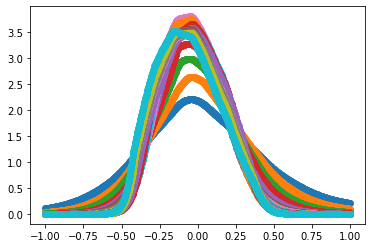

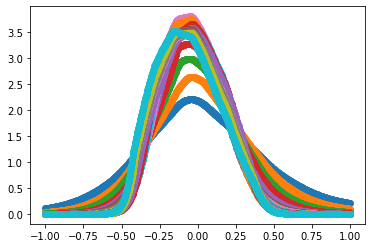

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)
for i in range(20):
    losses += train(net, optimizer, z0, z1, n_particles = 2, n_steps = 100)
    zgrid = np.linspace(-1, 1, 1000)
    x = net(torch.tensor(zgrid, dtype=torch.float32).cuda().unsqueeze(1)).squeeze(1).detach().cpu().numpy()
    x = 10**x
    norm =  x.sum()/len(zgrid)
    x = x/norm
    plt.scatter(zgrid, x)
    x1 = net(torch.tensor(z1, dtype=torch.float32).cuda().unsqueeze(1)).squeeze(1).detach().cpu().numpy()
    x1 = 10**x1/norm
    H = (np.log(x1)).sum()
    Hs.append(H)
    #plt.scatter(z0[:1000], x - max(x))
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
plt.plot(Hs)